# Understand RNN implementation

In this notebook we will have a look at how RNNs are implemented in `keras`.

The images are taken from https://colah.github.io/posts/2015-08-Understanding-LSTMs/

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

# Simple RNN

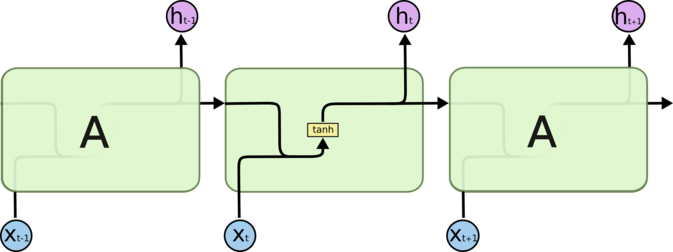

`layers.SimpleRNN` corresponds to the formula

$\vec{h}_t = \tanh(\mathbf{W_{xh}}\vec{x_t} + \mathbf{W_{hh}}\vec{h}_{t-1} + \vec{b})$

Let's build one with a hidden state size of 3 that takes inputs of shape `(batch_size, sequence_length, n_features)` with unspecified batch size and sequence length and 2 input features:

In [ ]:
rnn = layers.SimpleRNN(3)

In [ ]:
rnn.build((None, None, 2))

The weight matrix $\mathbf{W_{xh}}$ is called `kernel`

In [ ]:
rnn.cell.kernel

And the weight matrix $\mathbf{W_{hh}}$ is called `recurrent_kernel`

In [ ]:
rnn.cell.recurrent_kernel

<div class="alert alert-block alert-success">
Question: Do you understand the the shape of these matrices?
</div>

By default, there is also a bias vector:

In [ ]:
rnn.cell.bias

As a test input we use a batch with a single sequence of length 10 with random numbers:

In [ ]:
x = tf.random.uniform((1, 10, 2))
x

When we feed this through the RNN we get by default the **final** state after processing the whole sequence:

In [ ]:
rnn(x)

This can be changed by passing `return_sequences=True` to the RNN constructor:

In [ ]:
rnn2 = layers.SimpleRNN(3, return_sequences=True)
rnn2.build((None, None, 2))
rnn2.set_weights(rnn.get_weights())

Now we get the output after each step in the sequence - the last one should be equivalent to what we had before

In [ ]:
rnn2(x)

If we were to write out the loop explicitely that would look like this - if no initial state is given it starts with a 0-vector:

In [ ]:
def eval_rnn(rnn, x):
    state = tf.zeros((1, 3))
    output = []
    # loop over sequence
    for i in range(x.shape[1]):
        xi = x[:, i]
        state = tf.tanh(
            tf.matmul(state, rnn.cell.recurrent_kernel)
            + tf.matmul(xi, rnn.cell.kernel)
            + rnn.cell.bias
        )
        output.append(state)
    return tf.concat(output, axis=0)

In [ ]:
eval_rnn(rnn, x)

Also try out the equivalent formulation with a single weight matrix (corresponding to the concatenated `recurrent_kernel` and `kernel`) and concatenated input:

In [ ]:
initial_state = tf.zeros((1, 3))
tf.tanh(
    tf.matmul(
        tf.concat([initial_state, x[:, 0]], axis=1),
        tf.concat([rnn.cell.recurrent_kernel, rnn.cell.kernel], axis=0)
    ) + rnn.cell.bias
)

RNNs are trained with gradients from *Backpropagation through time* - this is nothing special when we do reverse-mode automatic differentiation and tensorflow will happily calculate gradients for us, e.g. with `tf.GradientTape` - for testing we just evaluate the gradient of the sum of final state vector components.

In [ ]:
with tf.GradientTape() as tape:
    f = tf.reduce_sum(eval_rnn(rnn, x)[-1])
tape.gradient(f, rnn.trainable_variables)

In [ ]:
with tf.GradientTape() as tape:
    f = tf.reduce_sum(rnn(x))
tape.gradient(f, rnn.trainable_variables)

# LSTM

The `LSTM` layer provides the exact same interface:

In [ ]:
lstm = layers.LSTM(3, return_sequences=True)

In [ ]:
lstm.build((None, None, 2))

In [ ]:
lstm(x)

## Optional exercise: reproduce the update rule

The 4 weight matrices (for 3 gates and the cell state update) are concatenated, (so here we will have matrices with 12 columns since we chose 3 units in the hidden state)

But also here they will also be split into the `kernel`, acting on the inputs and the `recurrent_kernel`, acting on the previous output:

In [ ]:
lstm.cell.kernel

In [ ]:
lstm.cell.recurrent_kernel

To reproduce the update we will concatenate the 2 kernels and then split into 4 weight matrices:

(order taken from https://github.com/keras-team/keras/blob/07e13740fd181fc3ddec7d9a594d8a08666645f6/keras/layers/rnn/lstm.py#L259)

In [ ]:
W_i, W_f, W_C, W_o = tf.split(
    tf.concat([lstm.cell.recurrent_kernel, lstm.cell.kernel], axis=0),
    4,
    axis=-1
)

Also for the bias:

In [ ]:
b_i, b_f, b_C, b_o = tf.split(lstm.cell.bias, 4)

In [ ]:
h_0 = tf.zeros((1, 3))
x_0 = tf.concat([h_0, x[:, 0]], axis=1)

### Forget gate

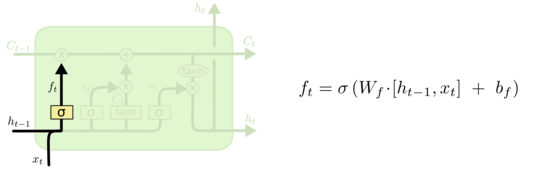

In [ ]:
f_1 = tf.sigmoid(tf.matmul(x_0, W_f) + b_f)

### Input gate

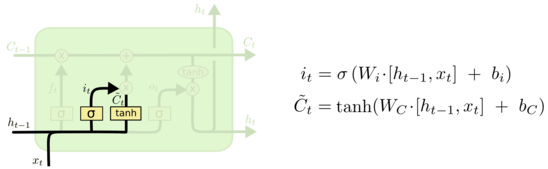

In [ ]:
i_1 = tf.sigmoid(tf.matmul(x_0, W_i) + b_i)

In [ ]:
C_tilde_1 = tf.tanh(tf.matmul(x_0, W_C) + b_C)

### Update cell state

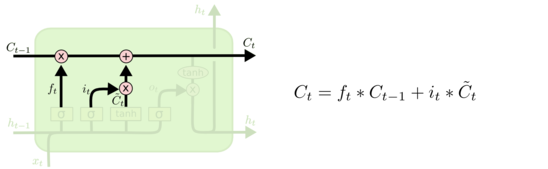

In [ ]:
C_0 = tf.zeros((1, 3))

In [ ]:
C_1 = f_1 * C_0 + i_1 * C_tilde_1

### Output gate

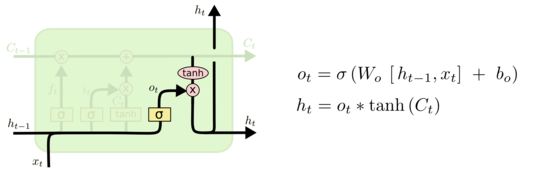

In [ ]:
o_1 = tf.sigmoid(tf.matmul(x_0, W_o) + b_o)

In [ ]:
h_1 = o_1 * tf.tanh(C_1)
h_1

cross check with the keras implementation:

In [ ]:
lstm(x)[:, 0]

Now loop over the whole sequence:

In [ ]:
def eval_lstm(lstm, x):
    W_i, W_f, W_C, W_o = tf.split(
        tf.concat([lstm.cell.recurrent_kernel, lstm.cell.kernel], axis=0),
        4,
        axis=-1
    )
    b_i, b_f, b_C, b_o = tf.split(lstm.cell.bias, 4)
    h_t = tf.zeros((1, 3))
    C_t = tf.zeros((1, 3))
    output = []
    for t in range(x.shape[1]):
        x_t = tf.concat([h_t, x[:, t]], axis=1)
        f_t = tf.sigmoid(tf.matmul(x_t, W_f) + b_f)
        i_t = tf.sigmoid(tf.matmul(x_t, W_i) + b_i)
        C_tilde_t = tf.tanh(tf.matmul(x_t, W_C) + b_C)
        C_t = f_t * C_t + i_t * C_tilde_t
        o_t = tf.sigmoid(tf.matmul(x_t, W_o) + b_o)
        h_t = o_t * tf.tanh(C_t)
        output.append(h_t)
    return tf.concat(output, axis=0)

In [ ]:
eval_lstm(lstm, x)

In [ ]:
lstm(x)